In [2]:
pip install fastf1

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [53]:
import fastf1
import fastf1.plotting 
import pandas as pd
import matplotlib.pyplot as mb
import os
import numpy as np

In [19]:
if not os.path.exists('cache'):
    os.makedirs('cache')
fastf1.Cache.enable_cache('cache')

In [20]:
fastf1.plotting.setup_mpl(miscmpl_mods=False)


In [21]:
session = fastf1.get_session(2021, 'Abu Dhabi', 'Q')
session.load()

core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '4', '11', '55', '77', '16', '22', '31', '3', '14', '10', '18', '99', '5', '6', '63', '7', '47', '9']


In [45]:
ver_lap=session.laps.pick_drivers('VER').pick_fastest()
ham_lap=session.laps.pick_drivers('HAM').pick_fastest()


In [46]:
ver_tel=ver_lap.get_car_data().add_distance()
ham_tel = ham_lap.get_car_data().add_distance()



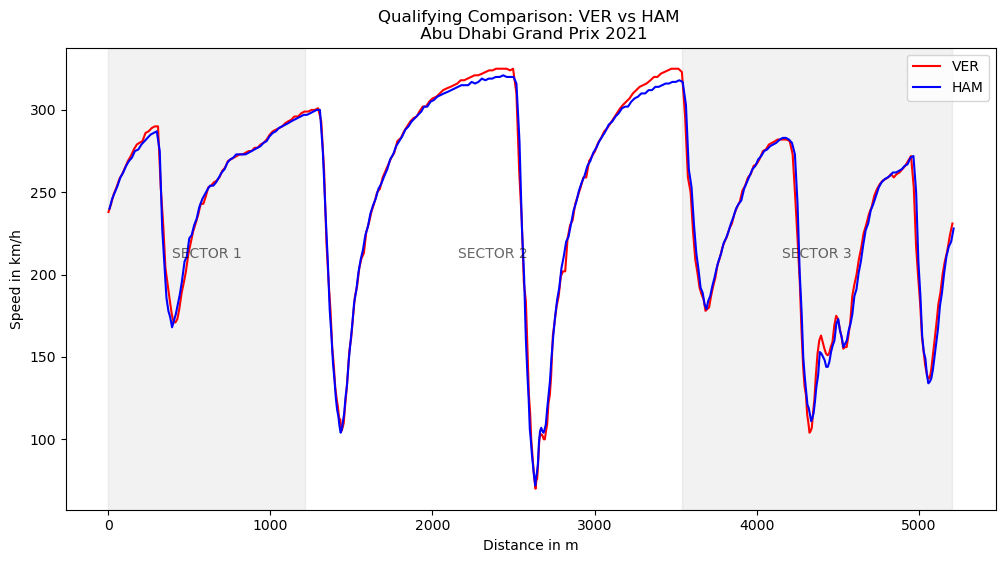

In [52]:
fig, ax = mb.subplots(figsize=(12, 6))
ax.plot(ver_tel['Distance'], ver_tel['Speed'],color='red',label='VER')
ax.plot(ham_tel['Distance'], ham_tel['Speed'],color='blue',label='HAM')
ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')
ax.legend()
ax.set_title(f"Qualifying Comparison: VER vs HAM \n {session.event['EventName']} 2021")

# ... (Previous plotting code) ...

# 1. Get Sector Times
sec1_time = ver_lap['Sector1Time']
sec2_time = ver_lap['Sector2Time']
sec3_time = ver_lap['Sector3Time']

# 2. Calculate End Times
t_sec1_end = sec1_time
t_sec2_end = sec1_time + sec2_time
t_sec3_end = sec1_time + sec2_time + sec3_time

# 3. Find Distances (With Error Handling)
# For Sector 1 and 2, we search for the time
d_sec1 = ver_tel.loc[ver_tel['Time'] >= t_sec1_end, 'Distance'].values[0]
d_sec2 = ver_tel.loc[ver_tel['Time'] >= t_sec2_end, 'Distance'].values[0]

# For Sector 3, we just take the end of the telemetry trace to be safe
d_sec3 = ver_tel['Distance'].max()

# 4. Add Shading
# Sector 1 (Gray)
ax.axvspan(0, d_sec1, color='gray', alpha=0.1)
# Sector 2 (White/Clear)
ax.axvspan(d_sec1, d_sec2, color='white', alpha=0.0)
# Sector 3 (Gray)
ax.axvspan(d_sec2, d_sec3, color='gray', alpha=0.1)

# Add Labels
ax.text(d_sec1/2, 210, 'SECTOR 1', ha='center', fontsize=10, alpha=0.6)
ax.text((d_sec1 + d_sec2)/2, 210, 'SECTOR 2', ha='center', fontsize=10, alpha=0.6)
ax.text((d_sec2 + d_sec3)/2, 210, 'SECTOR 3', ha='center', fontsize=10, alpha=0.6)

mb.show()
mb.show()

In [54]:
#finding delta i.e Laptime[Ham]-Laptime[Ver] the difference 
max_distance = ham_tel['Distance'].max()
distance_grid = np.linspace(0, max_distance, num=int(max_distance))


In [55]:
ver_seconds = ver_tel['Time'].dt.total_seconds()
ham_seconds = ham_tel['Time'].dt.total_seconds()

In [56]:
ver_time_interp = np.interp(distance_grid, ver_tel['Distance'], ver_seconds)
ham_time_interp = np.interp(distance_grid, ham_tel['Distance'], ham_seconds)

In [57]:
delta = ver_time_interp - ham_time_interp

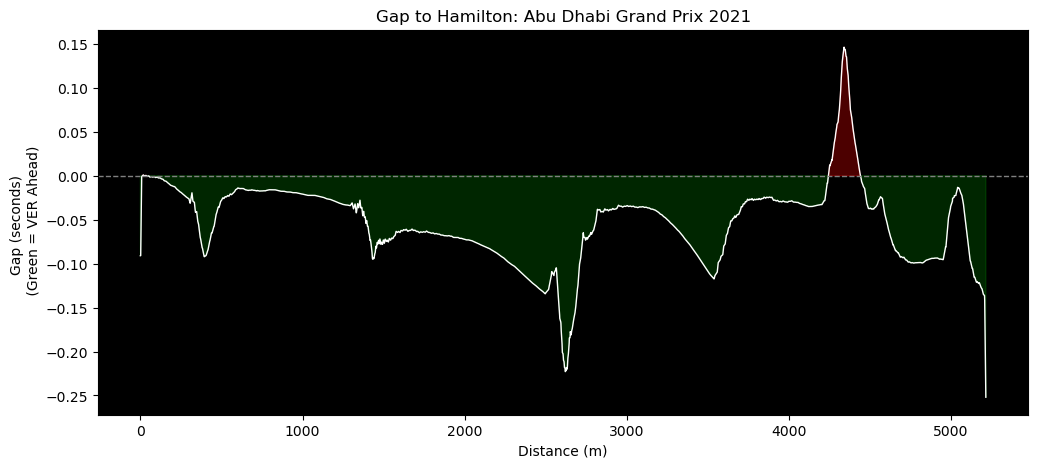

In [58]:
fig, ax = mb.subplots(figsize=(12, 5))

# Plot the main line
ax.plot(distance_grid, delta, color='white', linewidth=1)

# Add the "Zero" line (Dead Even)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# 6. Advanced Visualization: Color the gaps
# Green where VER is ahead (Delta < 0)
ax.fill_between(distance_grid, 0, delta, where=delta<0, color='green', alpha=0.3, interpolate=True)
# Red where VER is behind (Delta > 0)
ax.fill_between(distance_grid, 0, delta, where=delta>0, color='red', alpha=0.3, interpolate=True)

# Styling
ax.set_title(f"Gap to Hamilton: {session.event['EventName']} 2021")
ax.set_ylabel("Gap (seconds) \n (Green = VER Ahead)")
ax.set_xlabel("Distance (m)")
ax.set_facecolor('black') # Dark mode helps colors pop

mb.show()